In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
import matplotlib.pyplot as plt

In [2]:
# Cek device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [3]:
# Transformasi
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [4]:
# Load eMNIST (balanced split)
trainset = torchvision.datasets.EMNIST(root='./data', split='balanced', train=True, download=True, transform=transform)
testset = torchvision.datasets.EMNIST(root='./data', split='balanced', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

100%|██████████| 562M/562M [00:04<00:00, 123MB/s]


Extracting ./data/EMNIST/raw/gzip.zip to ./data/EMNIST/raw


In [5]:
# Cek label unik
print("Jumlah kelas:", len(trainset.classes))
print("Daftar kelas:", trainset.classes)

Jumlah kelas: 47
Daftar kelas: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']


In [6]:
# Model sederhana
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 47)  # eMNIST balanced = 47 kelas

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = nn.functional.log_softmax(x, dim=1)
        return output

model = SimpleCNN().to(device)

In [7]:
# Loss dan optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
for epoch in range(1):  # 1 epoch dulu
    running_loss = 0.0
    for batch_idx, (images, labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if batch_idx % 100 == 0:
            print(f"Epoch 1, Batch {batch_idx}, Loss: {loss.item():.4f}")

        if batch_idx >= 300:  # cuma 300 batch dulu
            break

/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 1, Batch 0, Loss: 0.8449
Epoch 1, Batch 100, Loss: 0.7618
Epoch 1, Batch 200, Loss: 0.5091
Epoch 1, Batch 300, Loss: 0.6076


In [12]:
# Evaluasi
correct = 0
total = 0
model.eval()
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Akurasi di data test: {100 * correct / total:.2f}%')

Akurasi di data test: 84.08%


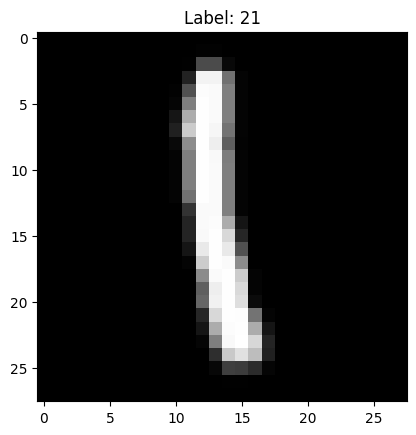

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Ambil satu batch dari trainloader
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Gambar pertama
img = images[0].squeeze()

# Rotate agar tampil normal (transpose + flip)
img = torch.rot90(img, k=1, dims=[1, 0])  # atau coba k=3 kalau masih terbalik

plt.imshow(img, cmap='gray')
plt.title(f"Label: {labels[0].item()}")
plt.show()


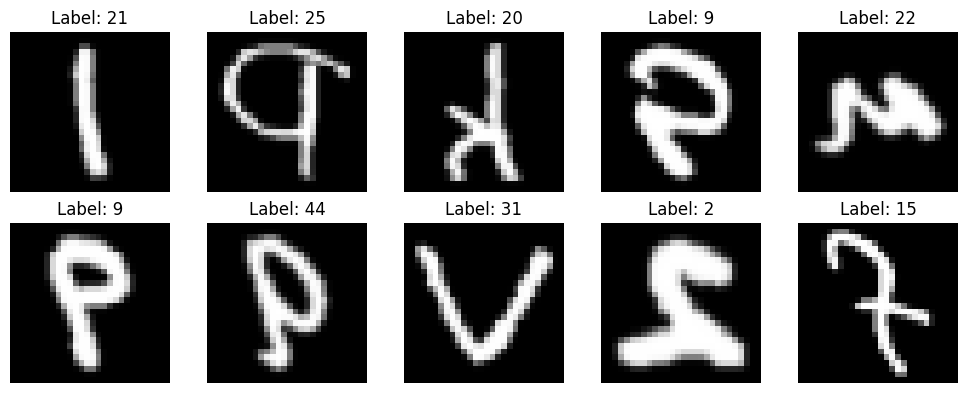

In [14]:
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    img = images[i].squeeze()
    img = torch.rot90(img, k=1, dims=[1, 0])  # perbaiki orientasi
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Label: {labels[i].item()}")
    ax.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)